# Code Executors

A code executor is a component that takes input messages (e.g., those containing code blocks), performs execution, and outputs messages with the results. AutoGen provides two types of built-in code executors, one is command line code executor, which runs code in a command line environment such as a UNIX shell, and the other is Jupyter executor, which runs code in an interactive Jupyter kernel

In [9]:
import os

from dotenv import load_dotenv
load_dotenv()

azure_deployment=os.getenv("AZURE_OPENAI_DEPLOYMENT")
azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT")
api_key=os.getenv("AZURE_OPENAI_KEY")

llm_config = [{"model": azure_deployment,
               "api_type": "azure",
               "temperature": 0.9,
               "api_key": api_key,
               "base_url": azure_endpoint,
               "api_version": "2024-02-15-preview"}] 

# Define a Code Executor

In [26]:
from autogen.coding import LocalCommandLineCodeExecutor

executor = LocalCommandLineCodeExecutor(
    timeout=60,
    work_dir="coding",
)

# Create agents

In [27]:
from autogen import ConversableAgent, AssistantAgent

code_executor_agent = ConversableAgent(
    name="code_executor_agent",
    llm_config=False,
    code_execution_config={"executor": executor},
    human_input_mode="ALWAYS",
    default_auto_reply=
    "Please continue. If everything is done, reply 'TERMINATE'.",
)

# https://microsoft.github.io/autogen/0.2/docs/reference/agentchat/assistant_agent/
# AssistantAgent is a subclass of ConversableAgent configured with a default system message. 
# The default system message is designed to solve a task with LLM, including suggesting python code blocks and debugging. 
# human_input_mode is default to "NEVER" and code_execution_config is default to False. 
# This agent doesn't execute code by default, and expects the user to execute the code.
code_writer_agent = AssistantAgent(
    name="code_writer_agent",
    llm_config={"config_list": llm_config},
    code_execution_config=False,
    human_input_mode="NEVER",
)

# check default system message of the Assistant Agent
print(code_writer_agent.system_message)


You are a helpful AI assistant.
Solve tasks using your coding and language skills.
In the following cases, suggest python code (in a python coding block) or shell script (in a sh coding block) for the user to execute.
    1. When you need to collect info, use the code to output the info you need, for example, browse or search the web, download/read a file, print the content of a webpage or a file, get the current date/time, check the operating system. After sufficient info is printed and the task is ready to be solved based on your language skill, you can solve the task by yourself.
    2. When you need to perform some task with code, use the code to perform the task and output the result. Finish the task smartly.
Solve the task step by step if you need to. If a plan is not provided, explain your plan first. Be clear which step uses code, and which step uses your language skill.
When using code, you must indicate the script type in the code block. The user cannot provide any other feed

# The task
Ask the two agents to collaborate on a stock analysis task.

In [28]:
import datetime

today = datetime.datetime.now().date()
message = f"Today is {today}. "\
"Create a plot showing stock gain YTD for NVDA and TLSA. "\
"Make sure the code is in markdown code block and save the figure"\
" to a file ytd_stock_gains.png."""

chat_result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message=message,
)

code_executor_agent (to code_writer_agent):

Today is 2024-11-11. Create a plot showing stock gain YTD for NVDA and TLSA. Make sure the code is in markdown code block and save the figure to a file ytd_stock_gains.png.

--------------------------------------------------------------------------------
code_writer_agent (to code_executor_agent):

To create a plot showing stock gain YTD (Year-to-Date) for NVDA (NVIDIA Corporation) and TSLA (Tesla, Inc.) and save the figure to a file `ytd_stock_gains.png`, we will use the `yfinance` library to fetch the stock data and `matplotlib` to create the plot.

Here’s the plan:
1. Fetch the YTD stock data for NVDA and TSLA using `yfinance`.
2. Calculate the percentage gain YTD for each stock.
3. Plot the data using `matplotlib`.
4. Save the figure to a file `ytd_stock_gains.png`.

Let's proceed with the code:

```python
# filename: plot_stock_gains.py

import yfinance as yf
import matplotlib.pyplot as plt
import datetime

# Define the tickers
tickers 

# Plot Result

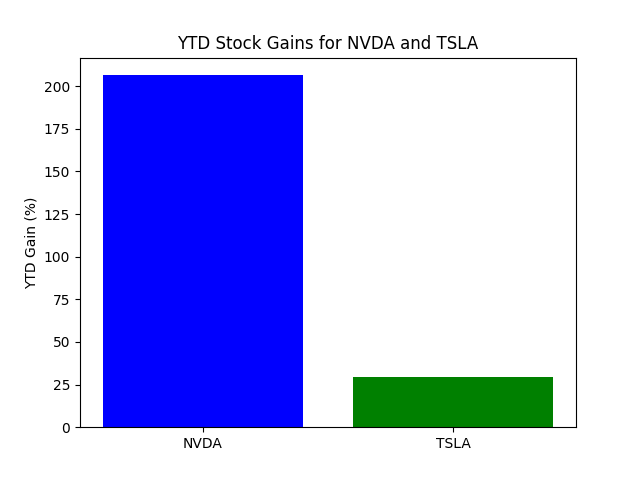

In [29]:
import os
from IPython.display import Image

Image(os.path.join("coding", "ytd_stock_gains.png"))

# Cleanup Working Directory

In [30]:
# Because code execution leave traces like code files and output in the file system, 
# we may want to clean up the working directory after each conversation concludes.
# cleanup coding directory
import shutil
shutil.rmtree("coding", ignore_errors=True)

# User-Defined Functions
Instead of asking LLM to generate the code for downloading stock data and plotting charts each time, you can define functions for these two tasks and have LLM call these functions in the code.

In [31]:
def get_stock_prices(stock_symbols, start_date, end_date):
    """Get the stock prices for the given stock symbols between
    the start and end dates.

    Args:
        stock_symbols (str or list): The stock symbols to get the
        prices for.
        start_date (str): The start date in the format 
        'YYYY-MM-DD'.
        end_date (str): The end date in the format 'YYYY-MM-DD'.
    
    Returns:
        pandas.DataFrame: The stock prices for the given stock
        symbols indexed by date, with one column per stock 
        symbol.
    """
    import yfinance

    stock_data = yfinance.download(
        stock_symbols, start=start_date, end=end_date
    )
    return stock_data.get("Close")

def plot_stock_prices(stock_prices, filename):
    """Plot the stock prices for the given stock symbols.

    Args:
        stock_prices (pandas.DataFrame): The stock prices for the 
        given stock symbols.
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))
    for column in stock_prices.columns:
        plt.plot(
            stock_prices.index, stock_prices[column], label=column
                )
    plt.title("Stock Prices")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.savefig(filename)

# Create a new executor with the user-defined functions then create the Agents

In [36]:
executor = LocalCommandLineCodeExecutor(
    timeout=60,
    work_dir="coding",
    functions=[get_stock_prices, plot_stock_prices],
)

code_executor_agent = ConversableAgent(
    name="code_executor_agent",
    llm_config=False,
    code_execution_config={"executor": executor},
    human_input_mode="ALWAYS",
    default_auto_reply=
    "Please continue. If everything is done, reply 'TERMINATE'.",
)

# https://microsoft.github.io/autogen/0.2/docs/reference/agentchat/assistant_agent/
# AssistantAgent is a subclass of ConversableAgent configured with a default system message. 
# The default system message is designed to solve a task with LLM, including suggesting python code blocks and debugging. 
# human_input_mode is default to "NEVER" and code_execution_config is default to False. 
# This agent doesn't execute code by default, and expects the user to execute the code.
code_writer_agent = AssistantAgent(
    name="code_writer_agent",
    llm_config={"config_list": llm_config},
    code_execution_config=False,
    human_input_mode="NEVER",
)

# Perform Task
Earlier task was to show Year to Date Results. 
This task is to plot the stock prices

In [37]:
chat_result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message=f"Today is {today}."
    "Download the stock prices YTD for NVDA and TSLA and create"
    "a plot. Make sure the code is in markdown code block and "
    "save the figure to a file stock_prices_YTD_plot.png.",
)

code_executor_agent (to code_writer_agent):

Today is 2024-11-11.Download the stock prices YTD for NVDA and TSLA and createa plot. Make sure the code is in markdown code block and save the figure to a file stock_prices_YTD_plot.png.

--------------------------------------------------------------------------------
code_writer_agent (to code_executor_agent):

To complete this task, we will follow these steps:
1. Download the stock prices Year-To-Date (YTD) for NVDA and TSLA.
2. Create a plot based on the downloaded data.
3. Save the figure to a file named `stock_prices_YTD_plot.png`.

We will use Python to achieve this, utilizing libraries such as `yfinance` for downloading stock data, and `matplotlib` for plotting.

Here is the complete code:

```python
# filename: stock_prices_YTD_plot.py

import yfinance as yf
import matplotlib.pyplot as plt

# Define the stocks and date range
stock_symbols = ['NVDA', 'TSLA']
start_date = '2024-01-01'
end_date = '2024-11-11'

# Download the stock data

# Plot the results

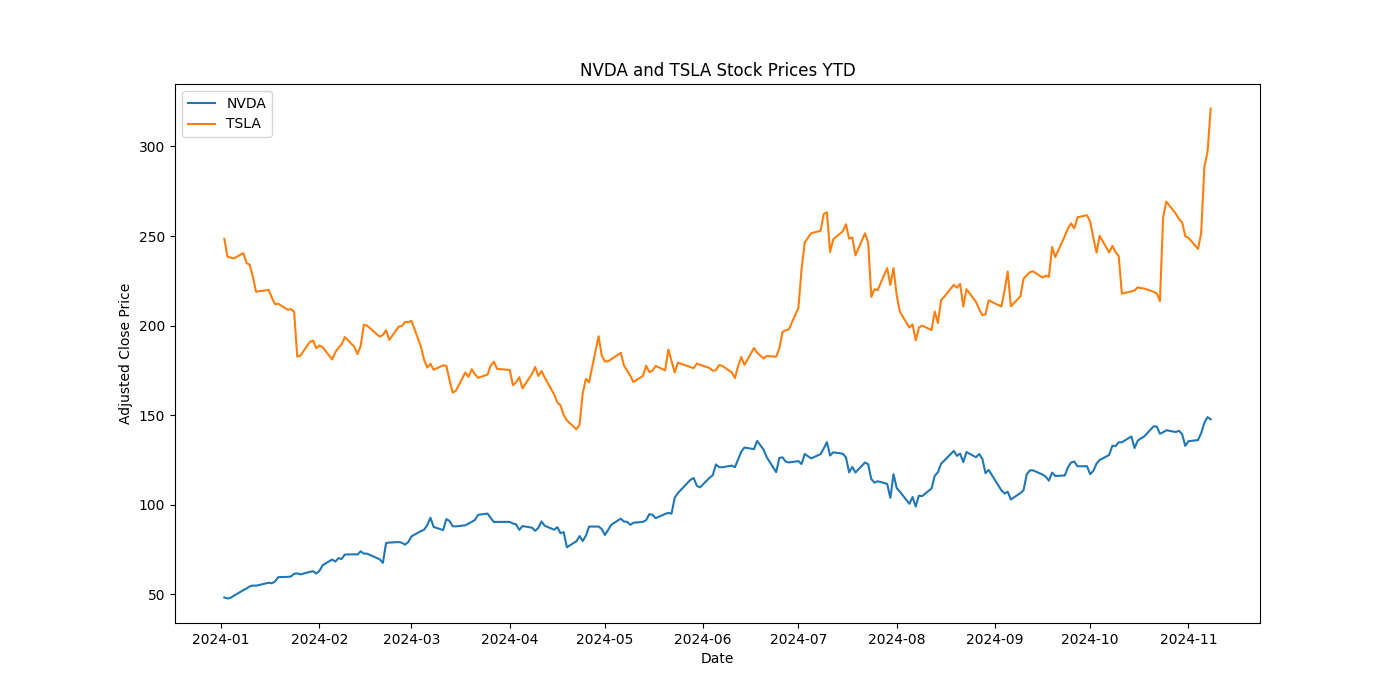

In [40]:
Image(os.path.join("coding", "stock_prices_YTD_plot.png"))

# Cleanup working directory

In [41]:
# Because code execution leave traces like code files and output in the file system, 
# we may want to clean up the working directory after each conversation concludes.
# cleanup coding directory
import shutil
shutil.rmtree("coding", ignore_errors=True)